# Predicting 2024 MLB Player Salaries 
(Last Updated Oct 2023)

I don't have as complicated of a model as Spotrac, but we can still have a quick go at it.

All payroll information is from [Spotrac](https://www.spotrac.com/mlb/)  and all player statistaics are from FanGraphs acceses via the [pybaseball package](https://github.com/jldbc/pybaseball)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pybaseball import batting_stats,pitching_stats,playerid_lookup
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error # MSE probably not ideal, but good enough for now
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

## Data Gathering
In order to allow for a comparison across different seasons, we adjust for [US inflation](https://www.usinflationcalculator.com/). Each player has a unique number as an identifier in FanGraphs. We use pybaseball.playerid_lookup() to find the FanGraphs ID for each player. (Names in the spotrac table do not have the spanish tilde, but allowing fuzzy=True allows for non-exact match cases.)

In [2]:
pay = pd.read_csv('salaries/2015-2023_active_salaries_adj_fgids.csv')
pay.head()

,year,team,first_name,last_name,pay,age,position,status,Season,team_abbrev,log_pay,adj,pay_adj,log_pay_adj,fgid
0,2015,Arizona Diamondbacks,Aaron,Hill,12000000.0,33,3B,Vet,2015,ARI,7.079181,1.295,1.554000e+07,7.191451,6104
1,2015,Arizona Diamondbacks,Yasmany,Tomas,5379781.0,24,LF,Vet,2015,ARI,6.730765,1.295,6.966816e+06,6.843034,17171
2,2015,Arizona Diamondbacks,Brad,Ziegler,5000000.0,35,RP,Vet,2015,ARI,6.698970,1.295,6.475000e+06,6.811240,7293
3,2015,Arizona Diamondbacks,Jeremy,Hellickson,4275000.0,28,SP,Vet,2015,ARI,6.630936,1.295,5.536125e+06,6.743206,4371
4,2015,Arizona Diamondbacks,Paul,Goldschmidt,3100000.0,27,1B,Vet,2015,ARI,6.491362,1.295,4.014500e+06,6.603631,9218


As mentioned, we can download and save the fangraphs stats using pybaseball. (I've already done this, so I'll just load them up.)

In [3]:
# get batting data for years 2015-2022
#data_bat = batting_stats(2014,2022, qual=1)
#data_bat.to_csv('stats/fg_batting2014-2022.csv', index=False)
data_bat=pd.read_csv('stats/fg_batting2014-2022.csv') 

# get fangraphs pitching stats for same year range
#data_pitch = pitching_stats(2014,2022, qual=1)
#data_pitch.to_csv('stats/fg_pitching2014-2022.csv', index=False)
data_pitch=pd.read_csv('stats/fg_pitching2014-2022.csv')

We can look at the stats of individual players if we like.

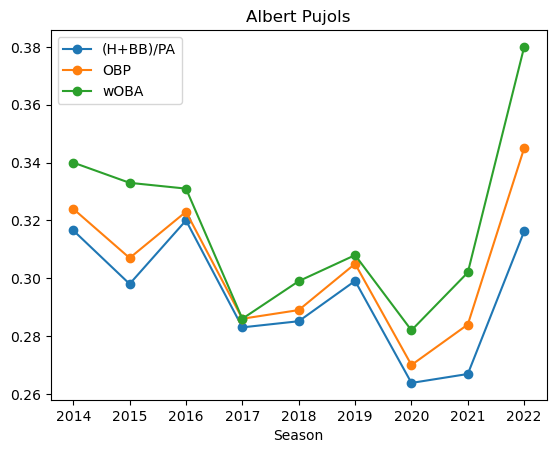

In [4]:
# look at a single player
player = data_bat[data_bat['IDfg']==1177].sort_values('Season')

plt.plot(player['Season'], (player['H']+player['BB'])/player['PA'], 'o-', label = '(H+BB)/PA')
plt.plot(player['Season'], player['OBP'], 'o-', label='OBP')
plt.plot(player['Season'], player['wOBA'], 'o-', label='wOBA')
plt.title(player['Name'].iloc[0])

plt.xlabel('Season')
plt.legend()

I'm going to spare you the various lines I use to match the yearly stats to the salaries and instead load in the final data frames.

In [5]:
pitchers = pd.read_csv('stats_and_pay_pitchers.csv')
batters = pd.read_csv('stats_and_pay_batters.csv')

## Initial Exploration
Immediately, we can check for any obvious factors that influence a player's salary.

<AxesSubplot:xlabel='age', ylabel='log_pay_adj'>

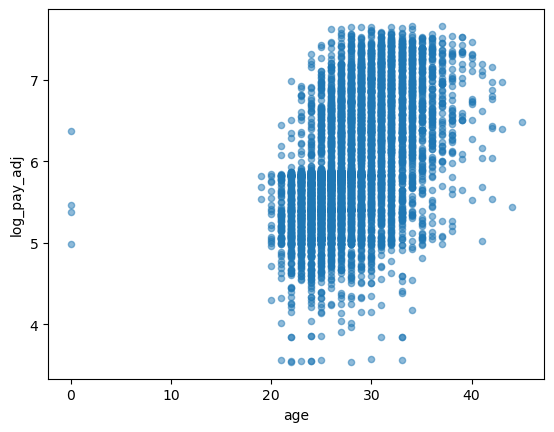

In [6]:
pay.plot.scatter(x="age", y="log_pay_adj", alpha=0.5)

Unsurprisingly, age influences the pay of baseball players. However, it's interesting to note that there's a positive correlation between age in pay. In some other sports, such as american football, there is worry about player performance declining with age. There is some of that thinking at play here but generally the increased skill that comes with time in the league seems to outweigh any worry about physical decline (at least with regards to salary).

Text(0, 0.5, 'log Season Salaries (adjusted for inflation 2023)')

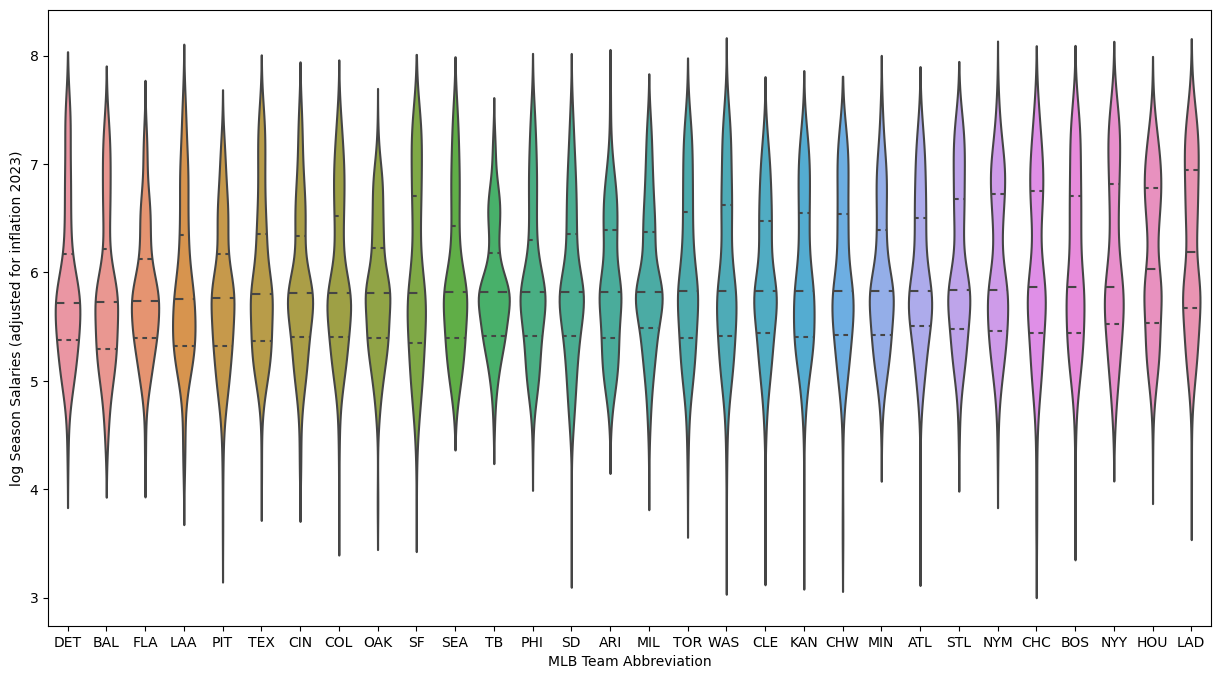

In [7]:
# what is the dependence on team? How signifigant is it?
fig,ax =plt.subplots(1,1,figsize=(15,8))
df_temp = pay[pay['pay']>0] # no nans

# get the median values and sort by them
medians = df_temp.groupby('team_abbrev')['log_pay_adj'].median()
sorting = medians.sort_values().index

sns.violinplot(data=df_temp,
               x = 'team_abbrev',
               y = 'log_pay_adj', 
               ax=ax,
               order=sorting,
               inner='quart')
ax.set_xlabel('MLB Team Abbreviation')
ax.set_ylabel('log Season Salaries (adjusted for inflation 2023)')

Text(0, 0.5, 'log Season Salaries (adjusted for inflation 2023)')

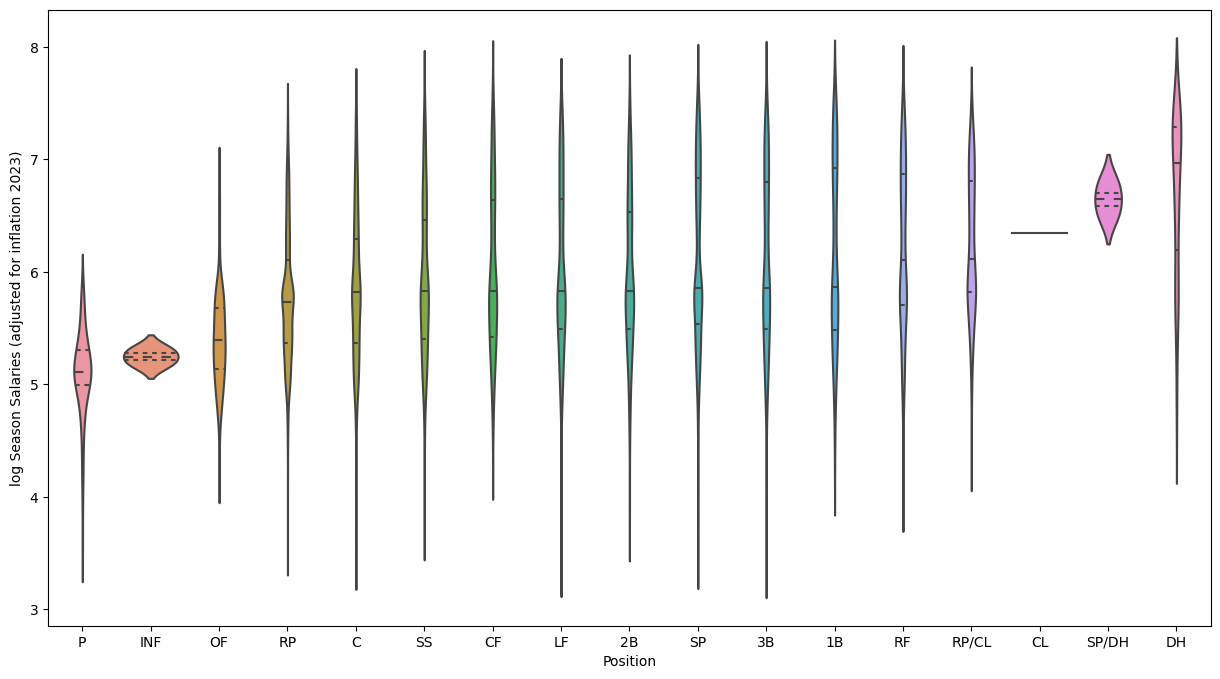

In [8]:
# let's make the same plot but by position
fig,ax =plt.subplots(1,1,figsize=(15,8))
df_temp = pay[pay['pay']>0] # no nans

# get the median values and sort by them
medians = df_temp.groupby('position')['log_pay_adj'].median()
sorting = medians.sort_values().index

sns.violinplot(data=df_temp,
               x = 'position',
               y = 'log_pay_adj', 
               ax=ax,
               order=sorting,
               inner='quart')
ax.set_xlabel('Position')
ax.set_ylabel('log Season Salaries (adjusted for inflation 2023)')

While there's little variation between the median pay between teams, there's certainly a dependance on position. Designated hitters are making almost 100 times more than pitchers on average. To make things simpler fo us, we're just going to make a split between pitchers and batters.

### Correlations
We can ask the question "What stats seem to influence pay the most?" and find out by calculating the correlation between pay and other stat columns.

In [9]:
# what initially seem like the stats that influcence pay the most for pitchers?
pitch_corr_df = pitchers.corr(numeric_only=True) # get the pearson-r correlation matrix

pay_corr_sort = np.abs(pitch_corr_df['log_pay_adj']).sort_values()[::-1].dropna() # sort by the columns that correlate the most with pay
nvals_in_cols = np.array([np.sum(~np.isnan(pitchers[col].values)) for col in pay_corr_sort.index])

pay_corr_sort[np.logical_and(nvals_in_cols>100, pay_corr_sort<1.0)].iloc[:20]

log_pay      0.999304
pay          0.759417
pay_adj      0.758381
p_+WPA       0.566196
Start-IP     0.542335
age          0.538780
p_SO         0.533826
p_-WPA       0.512991
p_RAR        0.511025
p_WAR        0.508348
IP           0.507773
p_Age        0.506878
p_Strikes    0.504516
Starting     0.504247
p_Pitches    0.496809
W            0.496412
TBF          0.494731
RA9-WAR      0.484037
p_Balls      0.478261
p_Events     0.471669
Name: log_pay_adj, dtype: float64

This is all well and good, but there quite a few degeneracies that we should be aware of so that we aren't using too many columns that all mean the same thing. Obviously all of the salary values are going to correlate (pay, log_pay, pay_adj, log_pay_adj) and the player's age is in three different columns technically, but there are also some degeneracies in the pitching stats. For instance, there's a positive correlation between pay and the number of walks (W). Why would that make sense? Teams certainly don't want value our pitchers higher because they're walking more batters, but the raw number of walks is going to natually scale with the number of pitches thrown (p_Pitches).

<AxesSubplot:xlabel='p_Pitches', ylabel='log_pay_adj'>

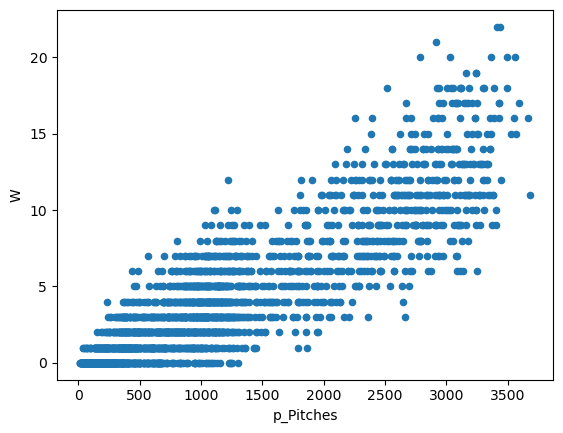

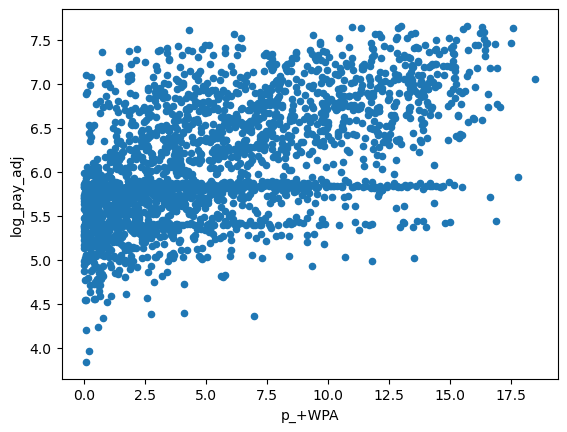

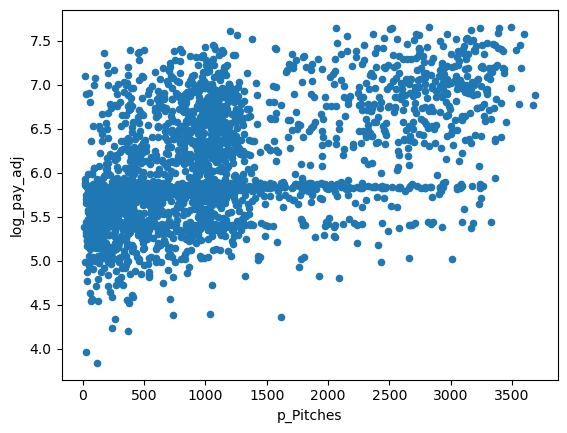

In [10]:
# visualize
df_temp = pitchers[pitchers['pay_adj']>0]
df_temp.plot.scatter(x='p_Pitches',y='W')
df_temp.plot.scatter(x='p_+WPA',y='log_pay_adj')
df_temp.plot.scatter(x='p_Pitches',y='log_pay_adj')

In [11]:
# what initially seem like the stats that influcence pay the most for batters?
bat_corr_df = batters.corr(numeric_only=True) # get the pearson-r correlation matrix

pay_corr_sort = np.abs(bat_corr_df['log_pay_adj']).sort_values()[::-1].dropna() # sort by the columns that correlate the most with pay
nvals_in_cols = np.array([np.sum(~np.isnan(batters[col].values)) for col in pay_corr_sort.index])

pay_corr_sort[np.logical_and(nvals_in_cols>100, pay_corr_sort<1.0)].iloc[:20]

log_pay      0.999362
pay_adj      0.793118
pay          0.788927
b_HardHit    0.593399
b_+WPA       0.588744
b_Balls      0.581863
wRC          0.581289
PA           0.579321
Rep          0.578915
b_Pitches    0.576576
b_Events     0.575730
RBI          0.574242
b_H          0.571153
b_FB         0.571140
AB           0.570826
b_R          0.567557
b_Strikes    0.567452
b_-WPA       0.562892
b_LD         0.559903
b_BB         0.549108
Name: log_pay_adj, dtype: float64

<AxesSubplot:xlabel='b_HardHit', ylabel='log_pay_adj'>

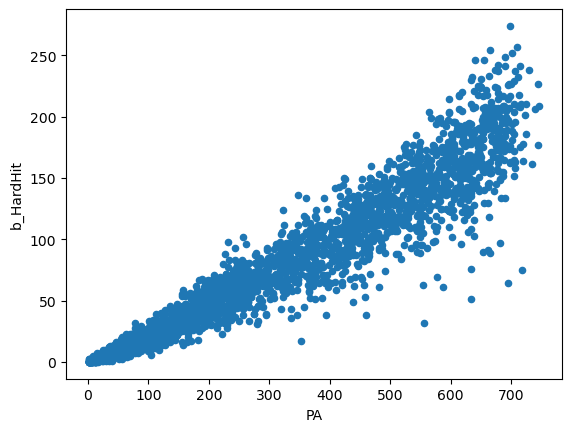

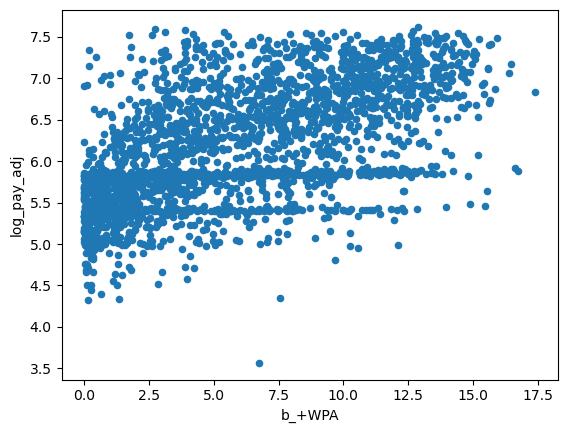

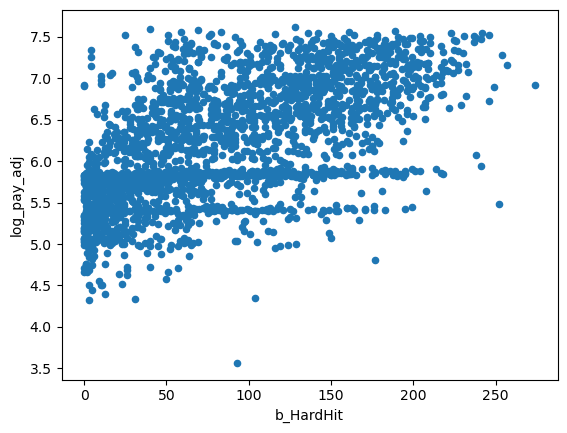

In [12]:
# visualize
df_temp = batters[batters['pay_adj']>0]
df_temp.plot.scatter(x='PA', y='b_HardHit')
df_temp.plot.scatter(x='b_+WPA',y='log_pay_adj')
df_temp.plot.scatter(x='b_HardHit',y='log_pay_adj')

Similar to the correlation between number of pitches and number of walks, there's a correlation betweeen number of hard hits a batter makes (b_HardHit) and the number of plate appearances (PA).

## PCA
We can try to account for the degeneracies using principal component analysis to pick out the most important features.

In [13]:
dp = pitchers.copy()
db = batters.copy()

### Pitchers
Let's start with looking at just the pitcher stat columns.

In [14]:
# let's try some PCA with all columns except pay

pca_p = PCA(n_components=15)
columns_mask = np.logical_and.reduce([dp.columns!='pay',dp.columns!='log_pay',
                                      dp.columns!='pay_adj', dp.columns!='log_pay_adj',
                                      dp.columns!='adj', dp.columns!='year',
                                      dp.columns!='Season',dp.columns!='Season_prev',
                                      dp.columns!='fgid',
                                      np.logical_or(dp.dtypes==np.float64,dp.dtypes==int)])



dp_pca = dp[dp.columns[columns_mask]].copy()
for col in dp_pca.columns:
    dp_pca[col] = dp_pca[col].fillna(np.nanmean(dp_pca[col].values)) # fill the nans with means to not influence the pca
dp_pca = dp_pca.fillna(0) # fill remaining nans
pca_p.fit(dp_pca.values)

len(np.max(pca_p.components_, axis=0)), len(dp_pca.columns)

/tmp/ipykernel_423/740623005.py:15: RuntimeWarning: Mean of empty slice
  dp_pca[col] = dp_pca[col].fillna(np.nanmean(dp_pca[col].values)) # fill the nans with means to not influence the pca


(392, 392)

We saw that pay scales with player age, so we want to establish an importance threshold that would allow age to be included. Similarly, the pitchers sum of the positive contrbutions to win probability added (p_+WPA) correlated relatively strongly with pay, so we ant to inclde it too.

In [15]:
# what is the max weight of age in the PCA columns?
np.max(pca_p.components_, axis=0)[dp_pca.columns=='age']

array([0.01088526])

In [16]:
# what is the max weight of +WPA in the PCA columns?
np.max(pca_p.components_, axis=0)[dp_pca.columns=='p_+WPA']

array([0.00758258])

Text(0, 0.5, '# of columns')

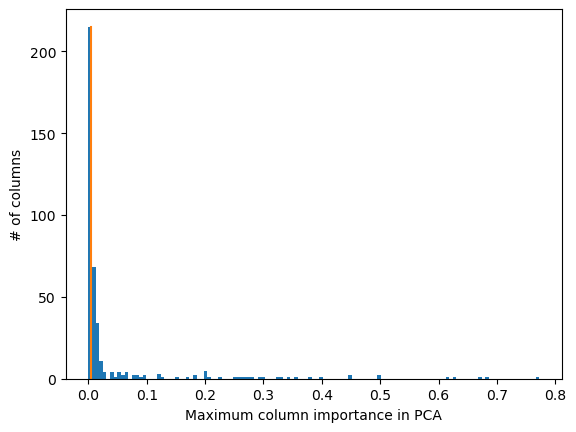

In [17]:
# what should the threshold be to find the most important columns?
thresh_p = 0.005
b = plt.hist(np.max(pca_p.components_, axis=0), bins=125)
plt.plot(np.ones(2)*thresh_p, [0,max(b[0])])
plt.xlabel('Maximum column importance in PCA')
plt.ylabel('# of columns')

In [18]:
# find the cols for which the pca has put the most weight on
dp_pca.columns[np.max(pca_p.components_, axis=0)>thresh_p], len(dp_pca.columns[np.max(pca_p.components_, axis=0)>thresh_p])

(Index(['age', 'p_Age', 'W', 'L', 'p_WAR', 'ERA', 'p_G', 'GS', 'SV', 'BS',
        ...
        'Stf+ SL', 'Loc+ SL', 'Pit+ SL', 'Stf+ FC', 'Loc+ FC', 'Pit+ FC',
        'Stf+ FS', 'Stuff+', 'Location+', 'Pitching+'],
       dtype='object', length=197),
 197)

In [19]:
# we've saving this cut table
dp_topcol = dp[['fgid','year','pay_adj','log_pay_adj']+list(dp_pca.columns[np.max(pca_p.components_, axis=0)>thresh_p])].copy()
dp_topcol.to_csv('stats_and_pay_pitchers_topcols.csv', index=False)

### Batters
We can do the same thing for the batter stats.

In [20]:
# let's try some PCA with all columns except pay
pca_b = PCA(n_components=15)
columns_mask = np.logical_and.reduce([db.columns!='pay',db.columns!='log_pay',
                                      db.columns!='pay_adj', db.columns!='log_pay_adj',
                                      db.columns!='adj', db.columns!='year',
                                      db.columns!='Season',db.columns!='Season_prev',
                                      db.columns!='fgid',
                                      np.logical_or(db.dtypes==np.float64,db.dtypes==int)])

db_pca = db[db.columns[columns_mask]].copy()
for col in db_pca.columns:
    db_pca[col].fillna(np.nanmean(db_pca[col].values),inplace=True) # fill the nans with means
db_pca = db_pca.fillna(-999) # fill remaining nans
pca_b.fit(db_pca.values)

len(np.max(pca_b.components_, axis=0)), len(db_pca.columns)

/tmp/ipykernel_423/636723824.py:12: RuntimeWarning: Mean of empty slice
  db_pca[col].fillna(np.nanmean(db_pca[col].values),inplace=True) # fill the nans with means


(319, 319)

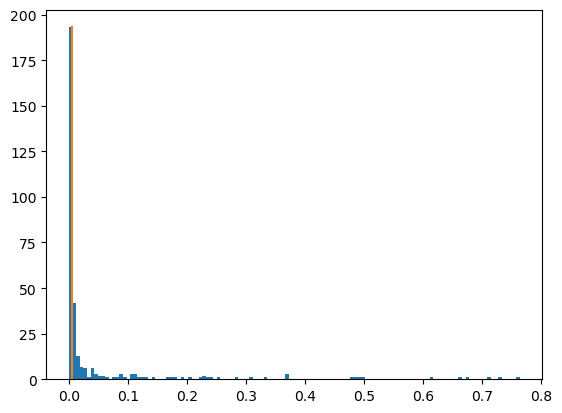

In [21]:
# what should the threshold be to find the most important columns?
thresh_b = 0.005
b = plt.hist(np.max(pca_b.components_, axis=0), bins=125)
plt.plot(np.ones(2)*thresh_b , [0,max(b[0])])

In [22]:
# find the cols for which the pca has put the most weight on
db_pca.columns[np.max(pca_b.components_, axis=0)>thresh_b ], len(db_pca.columns[np.max(pca_b.components_, axis=0)>thresh_b ])

(Index(['age', 'b_Age', 'b_G', 'AB', 'PA', 'b_H', '1B', '2B', '3B', 'b_HR',
        ...
        'b_Soft%+', 'b_Med%+', 'b_Hard%+', 'b_EV', 'b_LA', 'b_Barrels',
        'b_maxEV', 'b_HardHit', 'b_Events', 'L-WAR'],
       dtype='object', length=136),
 136)

In [23]:
# we've saving this cut table
db_topcol = db[['fgid','year','pay_adj','log_pay_adj']+list(db_pca.columns[np.max(pca_b.components_, axis=0)>thresh_b ])].copy()
db_topcol.to_csv('stats_and_pay_batters_topcols.csv', index=False)

## Data Split
Going to create a training and test split of the data we have.

In [24]:
dp = pd.read_csv('stats_and_pay_pitchers_topcols.csv')
db = pd.read_csv('stats_and_pay_batters_topcols.csv')

In [25]:
# do train/test split for each
train_p, test_p = train_test_split(dp.copy(), random_state=123)
train_b, test_b = train_test_split(db.copy(), random_state=456)

## Model Training/Comparison
We're going t o compare two simple models here. One is a linear regression model and the other is a random forest regression model.

In [26]:
# merge into a single df for combined use
train = pd.merge(train_p,train_b, on=['fgid','year','pay_adj','log_pay_adj'], how='outer')
test = pd.merge(test_p,test_b, on=['fgid','year','pay_adj','log_pay_adj'], how='outer')

# remove all the ones with zero pay
train = train[train['pay_adj']>0]
test = test[test['pay_adj']>0]

In [27]:
side_cols = ['fgid','year','Season','Season_prev','pay','log_pay','adj','pay_adj','log_pay_adj']

columns_mask = np.logical_and.reduce([~np.isin(db.columns,side_cols),
                                      np.logical_or(db.dtypes==np.float64, db.dtypes==int)])
batting_cols = train.columns[np.isin(train.columns,db.columns[columns_mask])]


columns_mask = np.logical_and.reduce([~np.isin(dp.columns,side_cols),
                                      np.logical_or(dp.dtypes==np.float64,dp.dtypes==int)])
pitching_cols = train.columns[np.isin(train.columns,dp.columns[columns_mask])]

In [28]:
%%time

# let's use the linear model as a baseline

# make an array of zeros that will hold our mses
mses = np.zeros((2, 5))

# keep track of what split we are on
i = 0


# Make a KFold object with k=5
kfold = KFold(n_splits = 5,
              shuffle = True,
              random_state = 8675309)

for train_index, test_index in kfold.split(train.copy()):
    
    
    ### Training
    train_x = train.iloc[train_index].copy().fillna(0)
    payx = train_x['log_pay_adj'].values
    train_xarr = train_x[list(pitching_cols)+list(batting_cols)].values
    
    
    ### Holdout set
    train_y = train.iloc[test_index].copy().fillna(0)
    payy = train_y['log_pay_adj'].values
    train_yarr = train_y[list(pitching_cols)+list(batting_cols)].values
    

    ## Model 3
    model1 = LinearRegression(copy_X=True)
    model1.fit(train_xarr, payx)
    pred1 = model1.predict(train_yarr)
    
    ## record MSE
    mses[0,i] = mean_squared_error(payy, pred1)
    
    ## random forest
    model2 = RandomForestRegressor(max_depth=12, random_state=None)
    model2.fit(train_xarr, payx)
    pred2 = regr.predict(train_yarr)
    ## record MSE
    mses[1,i] = mean_squared_error(payy, pred2)
    
    
    print('fold %i complete'%i)
    ## increase i by 1
    i = i + 1
    
for m,MSE in enumerate(mses.mean(axis=1)):
    print('Model %i mean MSE:'%(m+1), MSE)

NameError: name 'regr' is not defined

In [29]:
# now let's use the random forest model on the whole training and test set
lin = LinearRegression(copy_X=True)
full_train = train[list(pitching_cols)+list(batting_cols)].fillna(0).values
#full_train=poly.fit_transform(full_train) # add polynomials
lin.fit(full_train, train['log_pay_adj'].values)

full_test = test[list(pitching_cols)+list(batting_cols)].fillna(0).values
pred1 = lin.predict(full_test)

mean_squared_error(test['log_pay_adj'].values, pred1)

0.2620103181395965

In [30]:
# now let's use the random forest model on the whole training and test set
reg = RandomForestRegressor(max_depth=12, random_state=None)
full_train = train[list(pitching_cols)+list(batting_cols)].fillna(0).values
#full_train=poly.fit_transform(full_train) # add polynomials
reg.fit(full_train, train['log_pay_adj'].values)

full_test = test[list(pitching_cols)+list(batting_cols)].fillna(0).values
pred2 = reg.predict(full_test)

mean_squared_error(test['log_pay_adj'].values, pred2)

0.24116368743244557

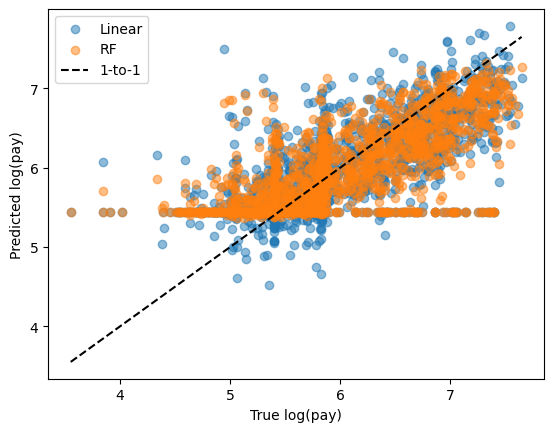

In [31]:
# while there's generally a linear correlation, it seems there is some sort of features we are missing
plt.scatter(test['log_pay_adj'].values, pred1, alpha=0.5, label='Linear')
plt.scatter(test['log_pay_adj'].values, pred2, alpha=0.5, label='RF')
plt.plot([min(test['log_pay_adj'].values), max(test['log_pay_adj'].values)],
         [min(test['log_pay_adj'].values), max(test['log_pay_adj'].values)],'k--', label='1-to-1')
plt.xlabel('True log(pay)')
plt.ylabel('Predicted log(pay)')
plt.legend()

Let's plot the residuals

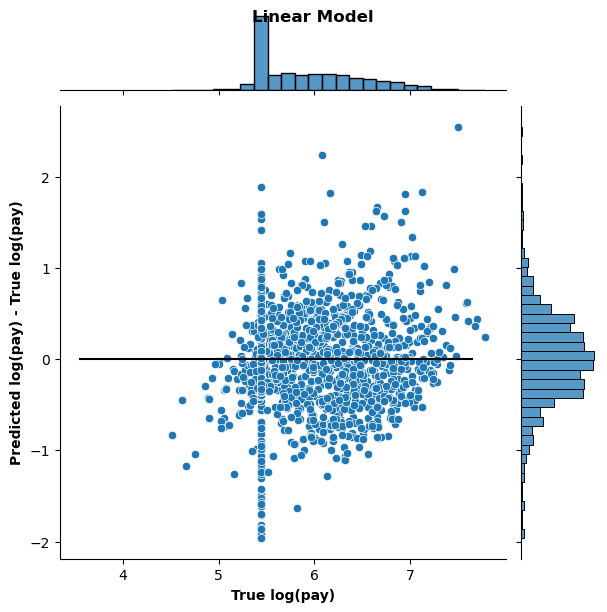

In [32]:
# plot the residuals
p = sns.jointplot(x=pred1,y=pred1-test['log_pay_adj'].values,kind='scatter')
p.ax_joint.set_xlabel('True log(pay)', fontweight='bold')
p.ax_joint.set_ylabel('Predicted log(pay) - True log(pay)', fontweight='bold')
p.fig.suptitle('Linear Model', fontweight='bold')
p.ax_joint.plot([min(test['log_pay_adj'].values),max(test['log_pay_adj'].values)], np.ones(2)*0,color='black',label='zero residuals')

In [33]:
np.mean(pred1-test['log_pay_adj'].values), np.median(pred1-test['log_pay_adj'].values)

(-0.009097344525557462, -0.0019653095926557285)

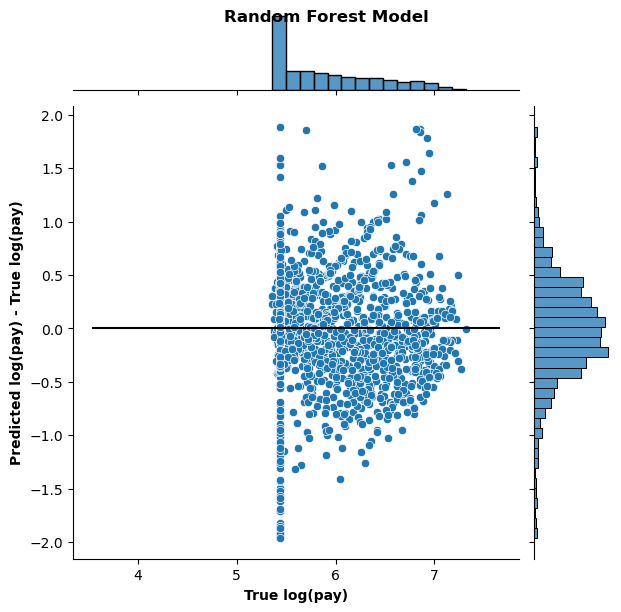

In [34]:
# plot the residuals
p = sns.jointplot(x=pred2,y=pred2-test['log_pay_adj'].values,kind='scatter')
p.ax_joint.set_xlabel('True log(pay)', fontweight='bold')
p.ax_joint.set_ylabel('Predicted log(pay) - True log(pay)', fontweight='bold')
p.fig.suptitle('Random Forest Model', fontweight='bold')
p.ax_joint.plot([min(test['log_pay_adj'].values),max(test['log_pay_adj'].values)], np.ones(2)*0,color='black',label='zero residuals')

In [35]:
np.mean(pred2-test['log_pay_adj'].values), np.median(pred2-test['log_pay_adj'].values)

(-0.01485857244833761, -0.013544233622280188)

The residuals are centered roughly on zero which is a good sign, but we're missing something that's making the vertical line in the residuals plot. Since it seems to come from incorrest predictions of players with roughly the same pay ($320,000), I think there's simply some more complexities that come in when evaluating players in that pay range. These complexities aren't being caputured by the "out-of-the-box" models like linear regressiona and random forest regression.

### Over-Under Estimation of our Model

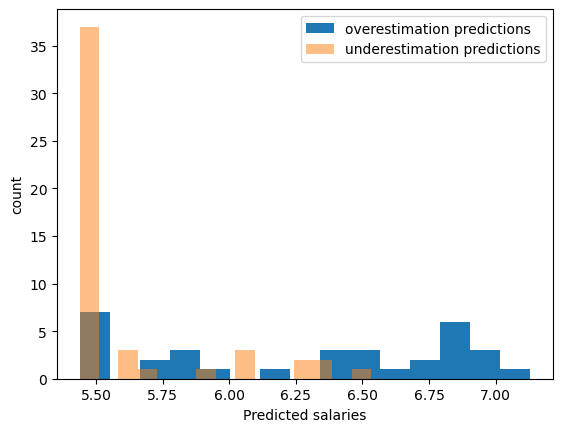

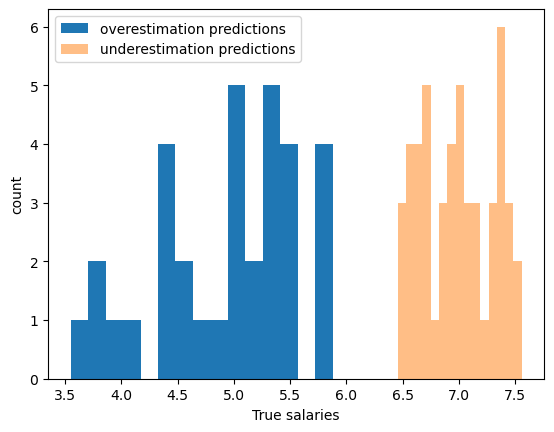

In [36]:
truths = test['log_pay_adj'].values

# let's define an acceptable range of error
error = 1.0 # we'll be generous and say we just want to get within a factor of 10

over_m = pred2-truths>error
under_m = pred2-truths<-error

plt.hist(pred2[over_m],bins=15, label='overestimation predictions')
plt.hist(pred2[under_m], bins=15,label='underestimation predictions', alpha=0.5)
plt.xlabel('Predicted salaries')
plt.ylabel('count')
plt.legend()

plt.figure()
plt.hist(truths[over_m],bins=15, label='overestimation predictions')
plt.hist(truths[under_m], bins=15,label='underestimation predictions', alpha=0.5)
plt.xlabel('True salaries')
plt.ylabel('count')
plt.legend()

## Free Agent Prediction

In [37]:
# combine all the datat we have into a training set
train0 = pd.merge(dp,db, on=['fgid','year','pay_adj','log_pay_adj'], how='outer')
train0 = train0[train0['pay_adj']>0]


side_cols = ['fgid','year','Season','Season_prev','pay','log_pay','adj','pay_adj','log_pay_adj']
columns_mask = np.logical_and.reduce([~np.isin(db.columns,side_cols),
                                      np.logical_or(db.dtypes==np.float64,db.dtypes==np.float64)])
batting_cols = train0.columns[np.isin(train0.columns,db.columns[columns_mask])]

columns_mask = np.logical_and.reduce([~np.isin(dp.columns,side_cols),
                                      np.logical_or(dp.dtypes==np.float64,dp.dtypes==np.float64)])
pitching_cols = train0.columns[np.isin(train0.columns,dp.columns[columns_mask])]

data_cols = list(pitching_cols)+list(batting_cols)

train = train0.copy().fillna(0)[data_cols].values
truths = train0['log_pay_adj'].values

In [38]:
%%time

## Linear regression model
lin = LinearRegression(copy_X=True)
lin.fit(train, truths)

## random forest
regr = RandomForestRegressor(max_depth=12, random_state=None)
regr.fit(train, truths)

CPU times: user 20.9 s, sys: 72.9 ms, total: 21 s
Wall time: 19.5 s


RandomForestRegressor(max_depth=12)

Now with our trained models, we need to pass through the datat for the 2023 season.

In [39]:
# get stats for the 2023 season
b2023 = pd.read_csv('stats/fg_batting2023.csv')
p2023 = pd.read_csv('stats/fg_pitching2023.csv')

In [40]:
# load the list of free agents
df_free=pd.read_csv('2024_free_agents.csv')

I'm just quickly checking if there are stats for all of the free agents in the 2023 tables

In [41]:
is_bat = np.isin(df_free['fgid'].values,b2023.loc[:,'IDfg'].values)
is_pitch = np.isin(df_free['fgid'].values,p2023.loc[:,'IDfg'].values)

np.logical_or(is_bat,is_pitch).sum() # maybe some people don't have 2023 stats

177

Looks like we're missing a chunk or free agents. This may be an issue with the web scraping or trying to use the player_lookup() function automatically. Regardless, let's go ahead and make some predictions for the 177 players we do have

In [42]:
# match them 
# create copies of the pitcher and batter stat dfs
db_new = b2023.loc[:, np.logical_and(b2023.columns != 'Season', b2023.columns != 'IDfg')].copy()
db_new['Season_prev'] = b2023.loc[:,'Season'].values
db_new['fgid'] = b2023.loc[:,'IDfg'].values

dp_new = p2023.loc[:, np.logical_and(p2023.columns != 'Season', p2023.columns != 'IDfg')].copy()
dp_new['Season_prev'] = p2023.loc[:,'Season'].values
dp_new['fgid'] = p2023.loc[:,'IDfg'].values

# there are some column names that are in both the batting and pitching tables
mapcol_p = {colname:'p_'+colname for colname in list(p2023.columns)[2:] if colname in list(b2023.columns)}
mapcol_b = {colname:'b_'+colname for colname in list(b2023.columns)[2:] if colname in list(p2023.columns)}

dp_new = dp_new.rename(columns=mapcol_p)
db_new = db_new.rename(columns=mapcol_b)

# merge
pitchers = pd.merge(df_free[is_pitch],dp_new, on=['fgid'], how='left')
batters = pd.merge(df_free[is_bat],db_new, on=['fgid'], how='left')
print(len(pitchers), len(batters),len(pitchers)+len(batters))

106 85 191


In [43]:
test0 = pd.merge(pitchers,batters, on=['fgid'], how='outer')
test = test0[data_cols].fillna(0).values
test.shape

(177, 331)

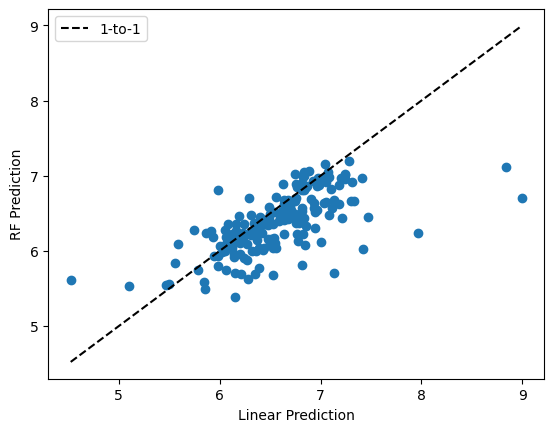

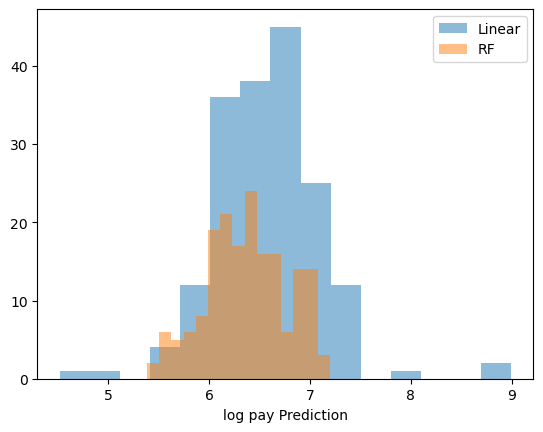

In [44]:
pred_1 = lin.predict(test)
pred_2 = regr.predict(test)
plt.scatter(pred_1, pred_2)
plt.xlabel('Linear Prediction')
plt.ylabel('RF Prediction')\

plt.plot([min(pred_1), max(pred_1)],
         [min(pred_1), max(pred_1)],'k--', label='1-to-1')
plt.legend()


plt.figure()
plt.hist(pred_1, bins=15,label='Linear', alpha=0.5)
plt.hist(pred_2, bins=15,label='RF', alpha=0.5)
plt.xlabel('log pay Prediction')
plt.legend()

In [45]:
# now let's print it out
columns = ("N", "FGid", "Name", "Salary 1", "Salary 2")
print("\t\t".join(columns))
for ind, row in enumerate(df_free[np.logical_or(is_bat,is_pitch)].iterrows()):
    d = (str(ind), str(row[1].fgid), row[1].FirstName+' '+row[1].LastName, '%.2f'%10**pred_1[ind],'%.2f'%10**pred_2[ind])
    print("\t\t".join(d))

N		FGid		Name		Salary 1		Salary 2
0		1744		miguel cabrera		690203546.21		12962203.88
1		19755		shohei ohtani		5880676.68		7122790.31
2		13431		marcus stroman		4936615.07		3986410.46
3		12979		javier báez		11075388.64		14342632.93
4		4314		joey votto		12621351.35		6617192.21
5		14444		hyun jin ryu		1162339.06		564288.69
6		2036		clayton kershaw		12235667.56		3033580.86
7		11899		joc pederson		16259220.32		2778715.65
8		2520		lance lynn		6827232.36		11217802.47
9		11368		yasmani grandal		3366097.35		1087564.65
10		16376		michael conforto		9483601.35		9414544.67
11		3548		liam hendriks		9620388.64		7648873.51
12		2233		adam wainwright		7201639.74		2148213.59
13		15998		cody bellinger		2325926.89		1696972.53
14		9368		evan longoria		1461606.44		1840927.84
15		5343		brandon crawford		6409558.40		2916778.01
16		13164		eduardo rodriguez		1597520.01		901937.86
17		14765		julio urías		4226002.80		7767662.80
18		14212		josh hader		4778946.50		4790003.77
19		13066		teoscar hernández		19095937.03	

These aren't *terribly unreasonable* predictions, but they're probaby not at all going to be close to the true value of each player's new contracts. Neither of these models take into account nuances like injuries and trading. For instance, Shohei Ohtani was injured during the regular season and so the raw counts of number of pitches and number of plate appearances, which seem to correlate the most with pay, are going to be smaller than they probably would be for a player who played all season. We also only included active players in the payroll sheet, so Shohei Ohtani and Mike Trout's 2023 salaries weren't included because they were not on the active players list at the end of the 2023 season.

Predicting a player's monetary worth is hard and there are multiple factors that go into the calculation that aren't always conveyed in the stats tables (even with the regular creation of improved sabermetrics). Even Sportac, which seems to use linear regression between "similar" players to compute market values, has predictions that are scaled by the salaries put forth by market trends. There is no "simple" way to calculate a player's worth. I would argue that, if anything, the model predictions here are underestimating the value of high-value players and over-estimating the value of lower-value players, a "regression to the mean" if you will.

So, how much money is Shohei Ohtani worth? Atleast $7,000,000.